In [ ]:
!pip install clarifai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.3/259.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.7/361.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.68.1
    Uninstalling grpcio-1.68.1:
      Succes

In [ ]:
from clarifai.client.model import Model
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import requests

In [ ]:
model_url = "https://clarifai.com/clarifai/main/models/apparel-detection"
detector_model = Model(
    url=model_url,
    pat="1fc718434f51433691094fcc989117ea",
)

Enter the full path of the image to test: /content/gettyimages-186543936-612x612.jpg


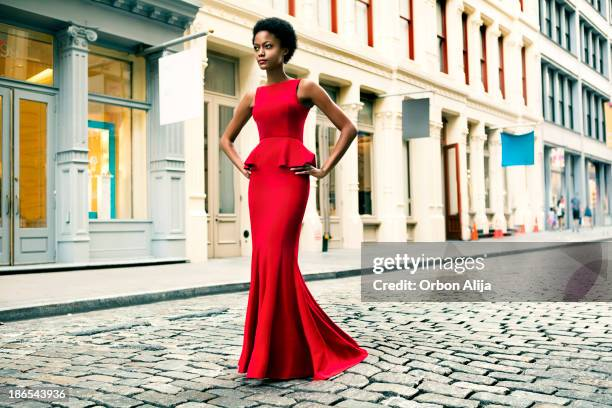

In [ ]:
CONFIDENCE_THRESHOLD = 0.6
all_detected_classes = []

# Input and store the image
image_path = input("Enter the full path of the image to test: ")
if not os.path.exists(image_path):
    print("The specified image does not exist! Please check the path.")
    exit()  # Exit the program if the image does not exist
else:
    with open(image_path, "rb") as img_file:
        Garment_img = cv2.imread(image_path)
        original_image = Garment_img.copy()
cv2_imshow(Garment_img)

In [ ]:
if os.path.exists(image_path):
    with open(image_path, "rb") as img_file:
        prediction_response = detector_model.predict_by_bytes(img_file.read(), input_type="image")

    regions = prediction_response.outputs[0].data.regions
    if not regions:
        print("No clothing items detected in the image.")
    else:
        image = cv2.imread(image_path)
        original_image = image.copy()

        for region in regions:
            top_row = region.region_info.bounding_box.top_row
            left_col = region.region_info.bounding_box.left_col
            bottom_row = region.region_info.bounding_box.bottom_row
            right_col = region.region_info.bounding_box.right_col

            height, width, _ = image.shape

            # Bounding box coordinates with bounds checking
            x1 = max(0, min(width, int(left_col * width)))
            y1 = max(0, min(height, int(top_row * height)))
            x2 = max(0, min(width, int(right_col * width)))
            y2 = max(0, min(height, int(bottom_row * height)))

            # Validate the bounding box
            if x1 >= x2 or y1 >= y2:
                print(f"Skipping invalid bounding box: x1={x1}, y1={y1}, x2={x2}, y2={y2}")
                continue

            for concept in region.data.concepts:
                confidence = concept.value
                if confidence >= CONFIDENCE_THRESHOLD:
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    label = f"{concept.name}: {confidence:.2f}"
                    cv2.putText(
                        image,
                        label,
                        (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 255, 0),
                        2,
                    )
                    all_detected_classes.append((concept.name, confidence))
                    break

Detected Classes:
- dress: 0.99
- skirt: 0.75


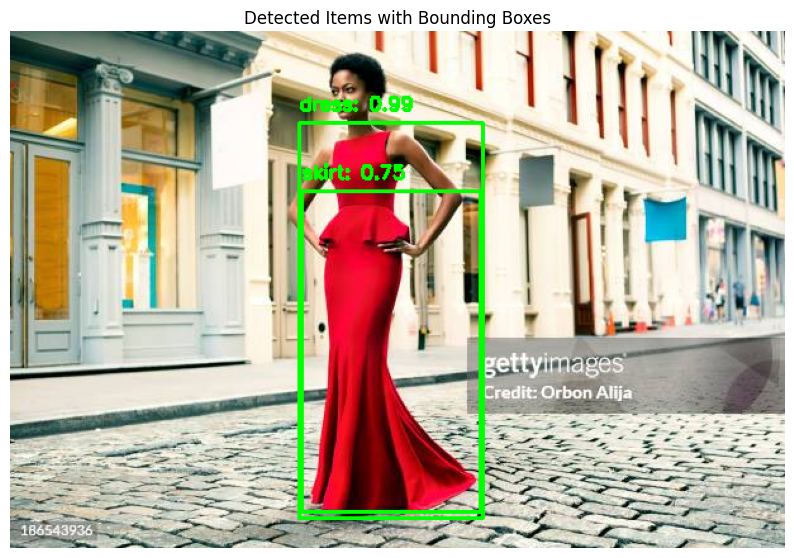

In [ ]:
if all_detected_classes:
    print("Detected Classes:")
    for class_name, confidence in all_detected_classes:
        print(f"- {class_name}: {confidence:.2f}")
else:
    print("No classes detected above the confidence threshold.")

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Items with Bounding Boxes")
plt.axis("off")
plt.show()


In [ ]:
PADDING_RATIO = 0.02
PADDING = int(PADDING_RATIO * min(width, height))
ROI_STORAGE = {}  # Dictionary to store filtered ROIs
ALLOWED_CLASSES = {"dress", "top" ,"pants"}  # Classes of interest

# Process all detected regions
for idx, region in enumerate(regions):
    # Bounding box coordinates
    top_row = region.region_info.bounding_box.top_row
    left_col = region.region_info.bounding_box.left_col
    bottom_row = region.region_info.bounding_box.bottom_row
    right_col = region.region_info.bounding_box.right_col

    height, width, _ = original_image.shape

    # Bounding box coordinates with bounds checking
    x1 = max(0, min(width, int(left_col * width))) - PADDING
    y1 = max(0, min(height, int(top_row * height))) - PADDING
    x2 = max(0, min(width, int(right_col * width))) + PADDING
    y2 = max(0, min(height, int(bottom_row * height))) + PADDING

    # Ensure bounding box is valid
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(width, x2)
    y2 = min(height, y2)

    # Crop the region of interest (ROI)
    roi = original_image[y1:y2, x1:x2]

    # Identify clothing type and confidence
    for concept in region.data.concepts:
        if concept.value >= CONFIDENCE_THRESHOLD and concept.name in ALLOWED_CLASSES:
            clothing_type = concept.name
            confidence = concept.value

            # Save the ROI in the storage
            roi_key = f"{clothing_type}_{idx}"  # Create a unique key for each ROI
            ROI_STORAGE[roi_key] = {
                "image": roi,
                "coordinates": (x1, y1, x2, y2),
                "confidence": confidence,
            }

            # Display cropped ROI (optional)
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title(f"{clothing_type} (Conf: {confidence:.2f})")
            plt.axis("off")
            plt.show()

            # Save ROI to file (optional)
            output_path = f"{clothing_type}_{idx}.jpg"
            cv2.imwrite(output_path, roi)

            break  # Only process the first valid concept per region

# Verify the stored ROIs
print(f"Number of ROIs saved: {len(ROI_STORAGE)}")
for key, value in ROI_STORAGE.items():
    print(f"{key}: {value['coordinates']} (Confidence: {value['confidence']:.2f})")


In [ ]:
def is_exactly_one_human(image_path, confidence_threshold=0.70):
    # Model paths
    model_path = "/content/frozen_inference_graph.pb"
    config_path = "/content/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt"

    # Load model
    net = cv2.dnn_DetectionModel(model_path, config_path)
    net.setInputSize(320, 320)
    net.setInputScale(1.0 / 127.5)
    net.setInputMean((127.5, 127.5, 127.5))
    net.setInputSwapRB(True)

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Perform detection
    class_ids, confidences, _ = net.detect(image, confThreshold=0.4, nmsThreshold=0.4)

    # Count humans with confidence above the threshold
    human_count = sum(1 for class_id, confidence in zip(class_ids.flatten(), confidences.flatten())
                      if class_id == 1 and confidence >= confidence_threshold)

    # Return True if exactly one human is detected
    return human_count == 1


In [ ]:
# Valid options
gender = ['Male', 'Female']
size = ['S', 'M', 'L']
category = ['Upper-Body', 'Lower-Body', 'Dress']

# Get gender input
while True:
    gender = input("Enter gender (Male/Female): ").strip().capitalize()
    if gender in gender:
        break
    print("Invalid input. Please choose from: Male, Female")

# Get size input
while True:
    size = input("Enter size (S/M/L): ").strip().upper()
    if size in size:
        break
    print("Invalid input. Please choose from: S, M, L.")

# Get garment category input
while True:
    category = input("Enter garment category (Upper-Body/Lower-Body/Dress): ").strip().capitalize()
    if category in category:
        break
    print("Invalid input. Please choose from: Upper-Body, Lower-Body, Dress.")

# Display user choices
print("\nUser Choices:")
print(f"Gender: {gender}")
print(f"Size: {size}")
print(f"Category: {category}")


Enter gender (Male/Female): Female
Enter size (S/M/L): S
Enter garment category (Upper-Body/Lower-Body/Dress): Dress

User Choices:
Gender: Female
Size: S
Category: Dress


In [ ]:
if gender == "Female":
    if size == "S":
        avatar_image_path = "/content/female_s.jpg"
    elif size == "M":
        avatar_image_path = "/content/female_m.jpg"
    elif size == "L":
        avatar_image_path = "/content/female_l.jpg"
    else:
        raise ValueError("Invalid size for Female. Please specify 'S', 'M', or 'L'.")
elif gender == "Male":
    if size == "S":
        avatar_image_path = "/content/male_s.jpg"
    elif size == "M":
        avatar_image_path = "/content/male_m.jpg"
    elif size == "L":
        avatar_image_path = "/content/male_l.jpg"
    else:
        raise ValueError("Invalid size for Male. Please specify 'S', 'M', or 'L'.")
else:
    raise ValueError("Invalid gender. Please specify 'Female' or 'Male'.")


In [ ]:
url = "https://try-on-diffusion.p.rapidapi.com/try-on-file"
headers = {
    "x-rapidapi-host": "try-on-diffusion.p.rapidapi.com",
    "x-rapidapi-key": "7554cb4da9mshc43e4b37fbf9910p1ad935jsn61c457d440c7",
}

files = {
    "clothing_image": ("clothing_image.jpg", open(image_path, "rb"), "image/jpeg"),
    "avatar_image": ("avatar_image.jpg", open(avatar_image_path, "rb"), "image/jpeg"),
}
data = {
    "clothing_prompt": "",
    "avatar_prompt": "",
    "background_prompt": "A white plain background",
    "seed": 42,
}

if is_exactly_one_human(image_path, confidence_threshold=0.70) and category == "Dress":

    response = requests.post(url, headers=headers, files=files, data=data)

    if response.status_code == 200:
        result = response.content
        with open("result_image.jpg", "wb") as f:
            f.write(response.content)
        print("Image generated successfully and saved as result_image.jpg.")
    else:
        print(f"Error: {response.status_code}")
        print(response.json())


Image generated successfully and saved as result_image.jpg.
